
📊 Processing SRTT Cumulative with Simple Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 20 outliers (4.2%) using 236 original features
  🔍 BASELINE:
    ✅ Cleaned 20 outliers (4.1%) using 236 original features

📊 Processing API Gateway Retrans with Simple Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 16 outliers (3.4%) using 1 original features
  🔍 BASELINE:
    ✅ Cleaned 0 outliers (0.0%) using 1 original features

📊 Processing Customers Service Retrans with Simple Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 16 outliers (3.4%) using 1 original features
  🔍 BASELINE:
    ✅ Cleaned 20 outliers (4.2%) using 1 original features

📊 Processing Visits Service Retrans with Simple Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 8 outliers (3.3%) using 1 original features
  🔍 BASELINE:
    ✅ Cleaned 7 outliers (2.3%) using 1 original features

📊 Processing Vets Service Retrans with Simple Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 8 outliers (3.8%) using 1 original features
  🔍 BASELINE

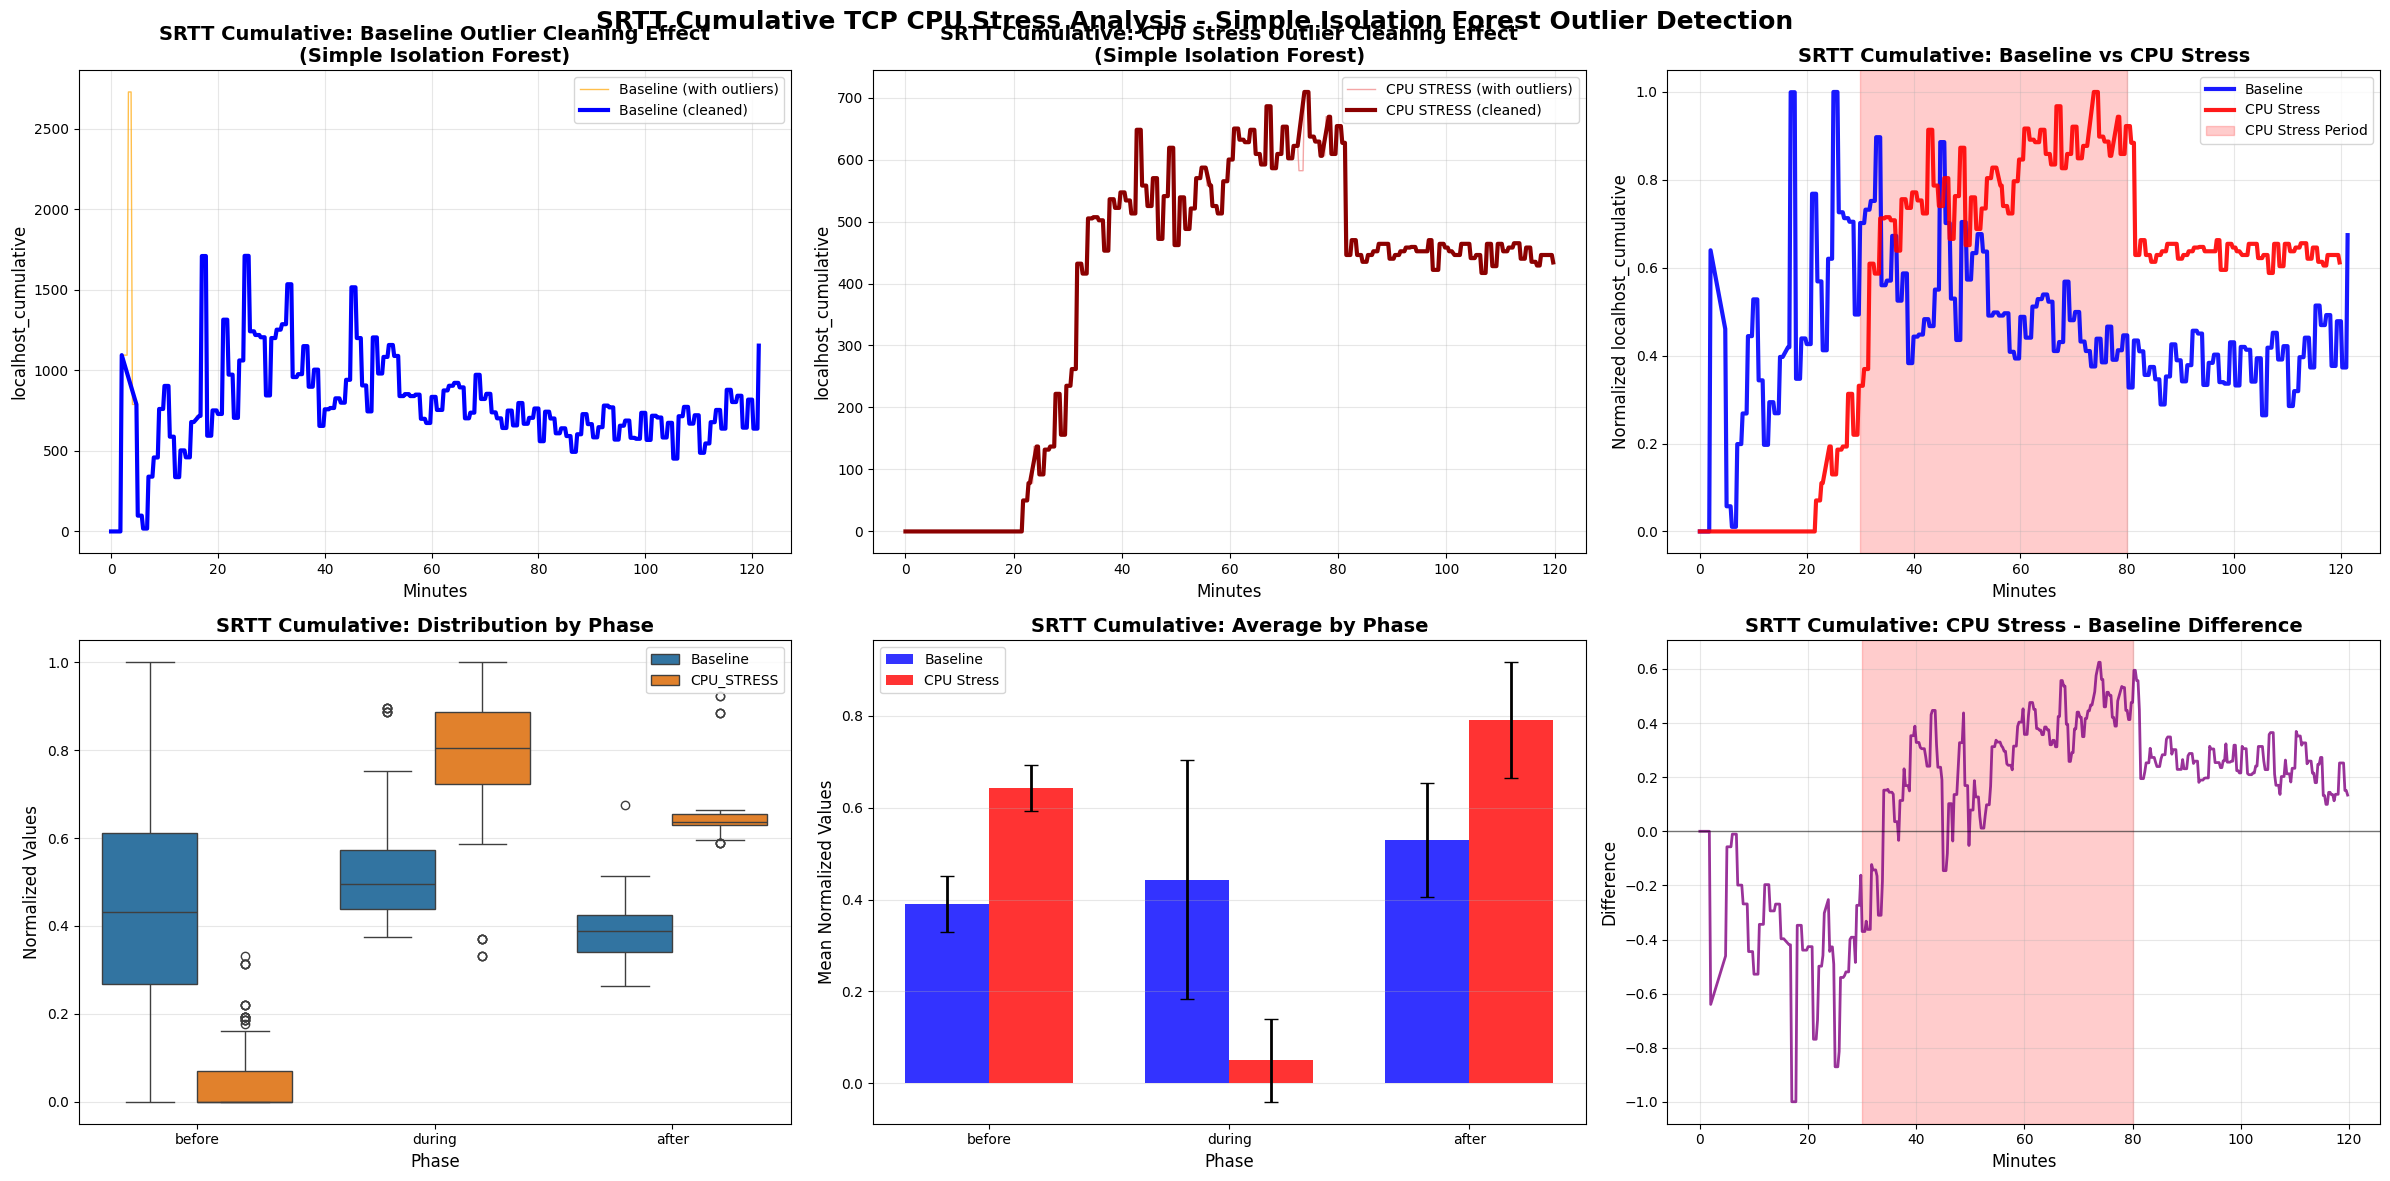


SRTT CUMULATIVE - TCP CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3902  0.0608  0.2643  0.6743
before  0.4432  0.2595  0.0000  1.0000
during  0.5297  0.1237  0.3754  0.8971

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6429  0.0499  0.5882  0.9224
before  0.0500  0.0900  0.0000  0.3315
during  0.7899  0.1263  0.3315  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 15.69, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-20.87, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=-40.81, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON TCP (% CHANGE):
  BEFORE  :  -88.73% (↘️ DECREASE)
  DURING  :  +49.11% (↗️ INCREASE)
  AFTER   :  +64.78% (↗️ INCREASE)

🔄 Analyzing API Gateway Retrans...


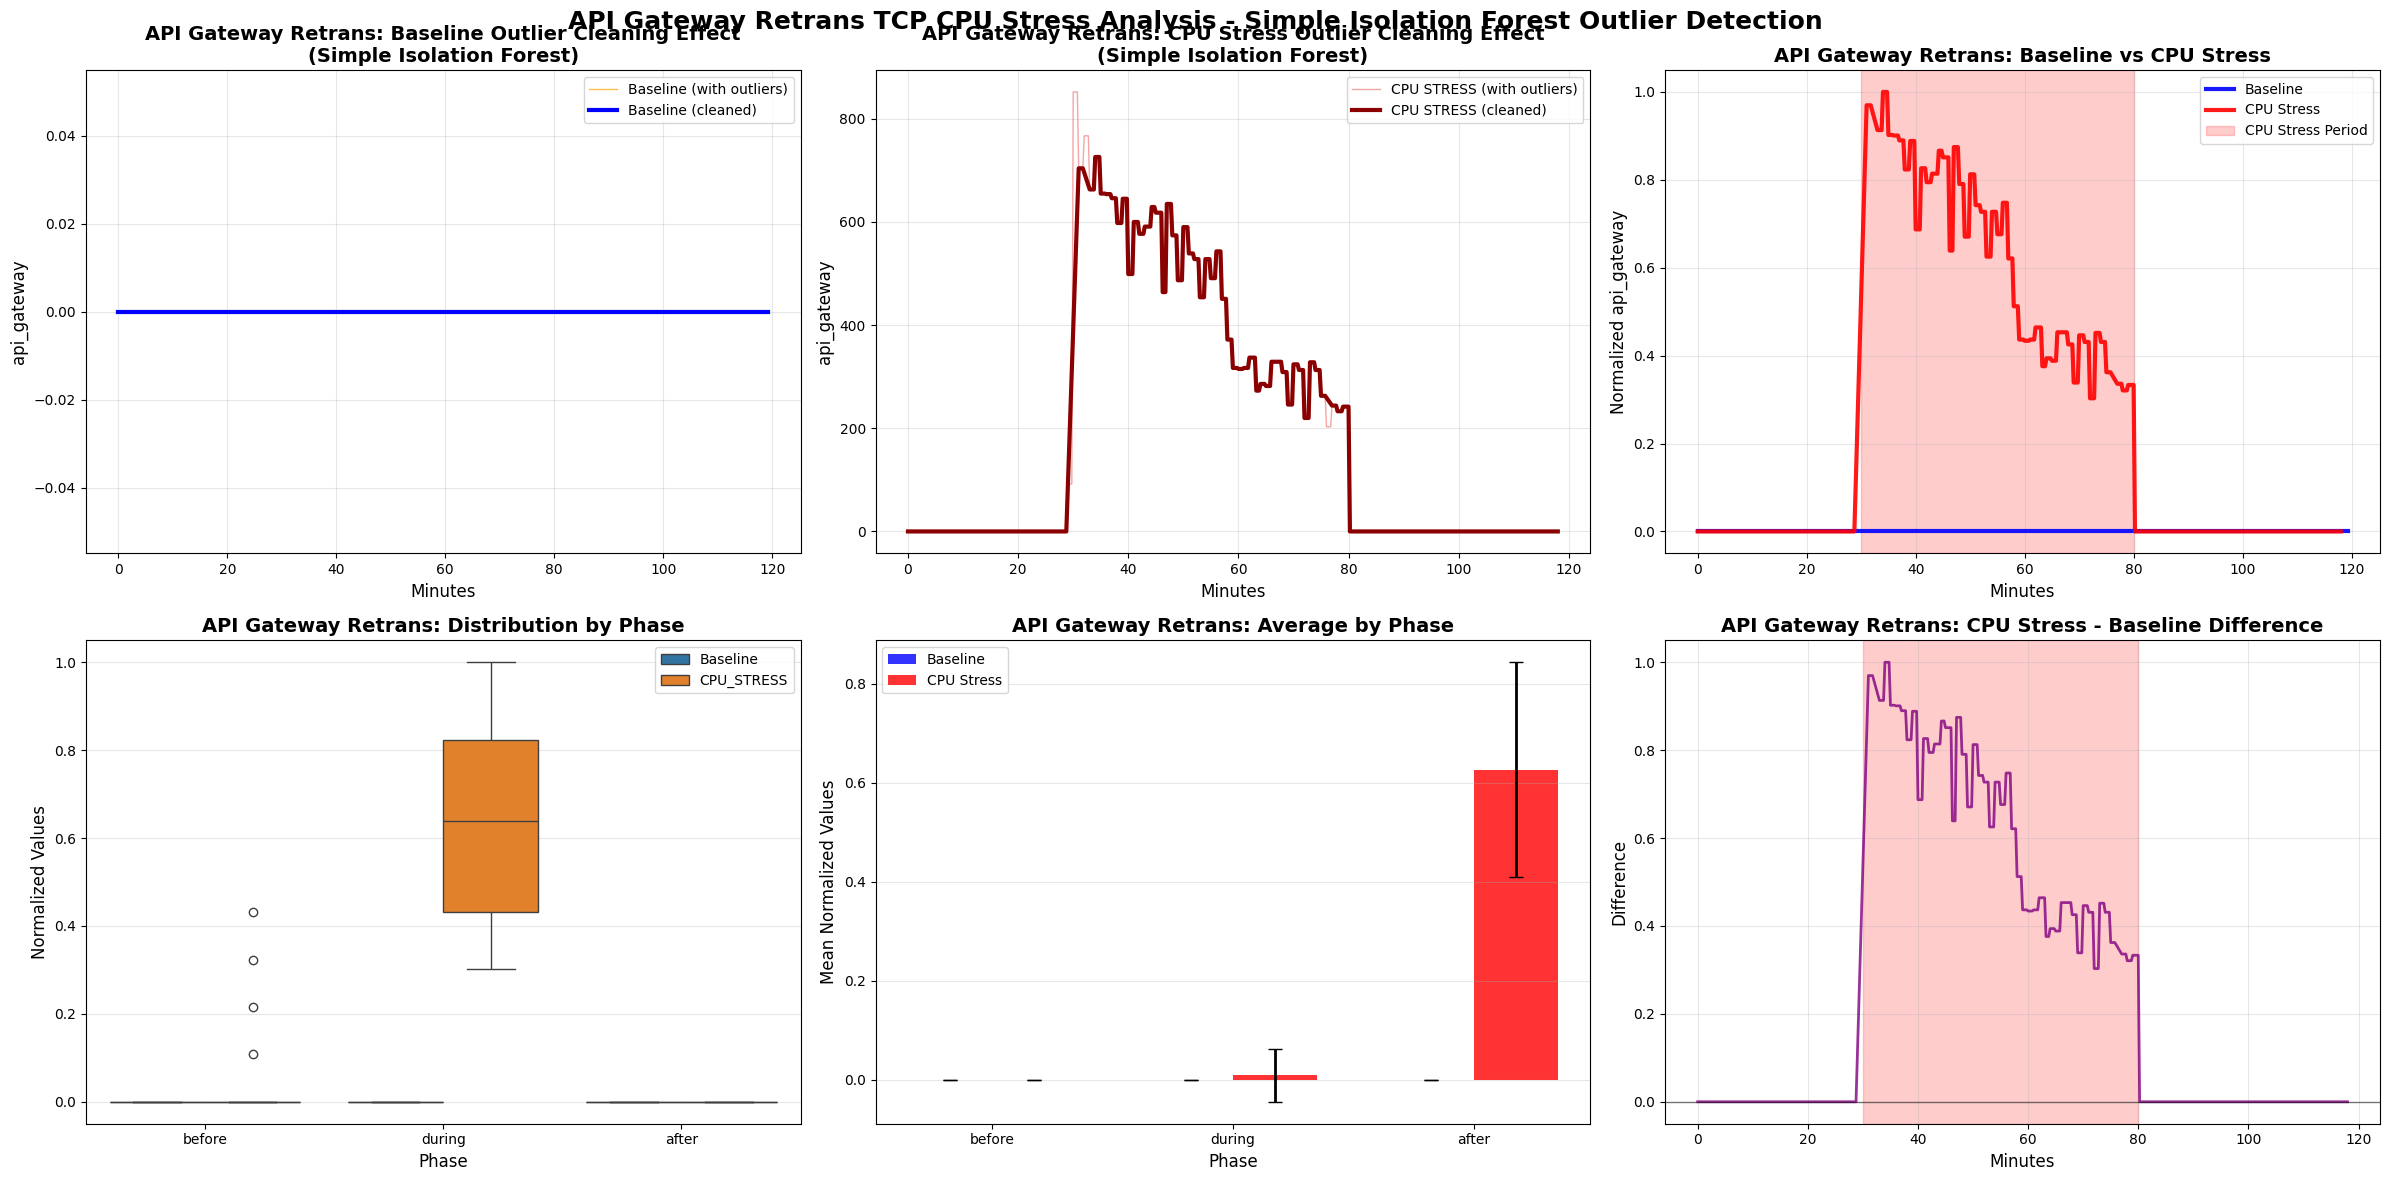


API GATEWAY RETRANS - TCP CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0    0    0
before   0.0  0.0    0    0
during   0.0  0.0    0    0

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std    min    max
phase                               
after   0.0000  0.0000  0.000  0.000
before  0.0090  0.0533  0.000  0.431
during  0.6258  0.2171  0.303  1.000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.84, p=  0.0664 (❌ NOT SIGNIFICANT)
  DURING  : t=-40.86, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=   nan, p=     nan (❌ NOT SIGNIFICANT)

📈 CPU STRESS IMPACT ON TCP (% CHANGE):
  BEFORE  :    +inf% (↗️ INCREASE)
  DURING  :    +inf% (↗️ INCREASE)
  AFTER   :    +inf% (↗️ INCREASE)

🔄 Analyzing Customers Service Retrans...


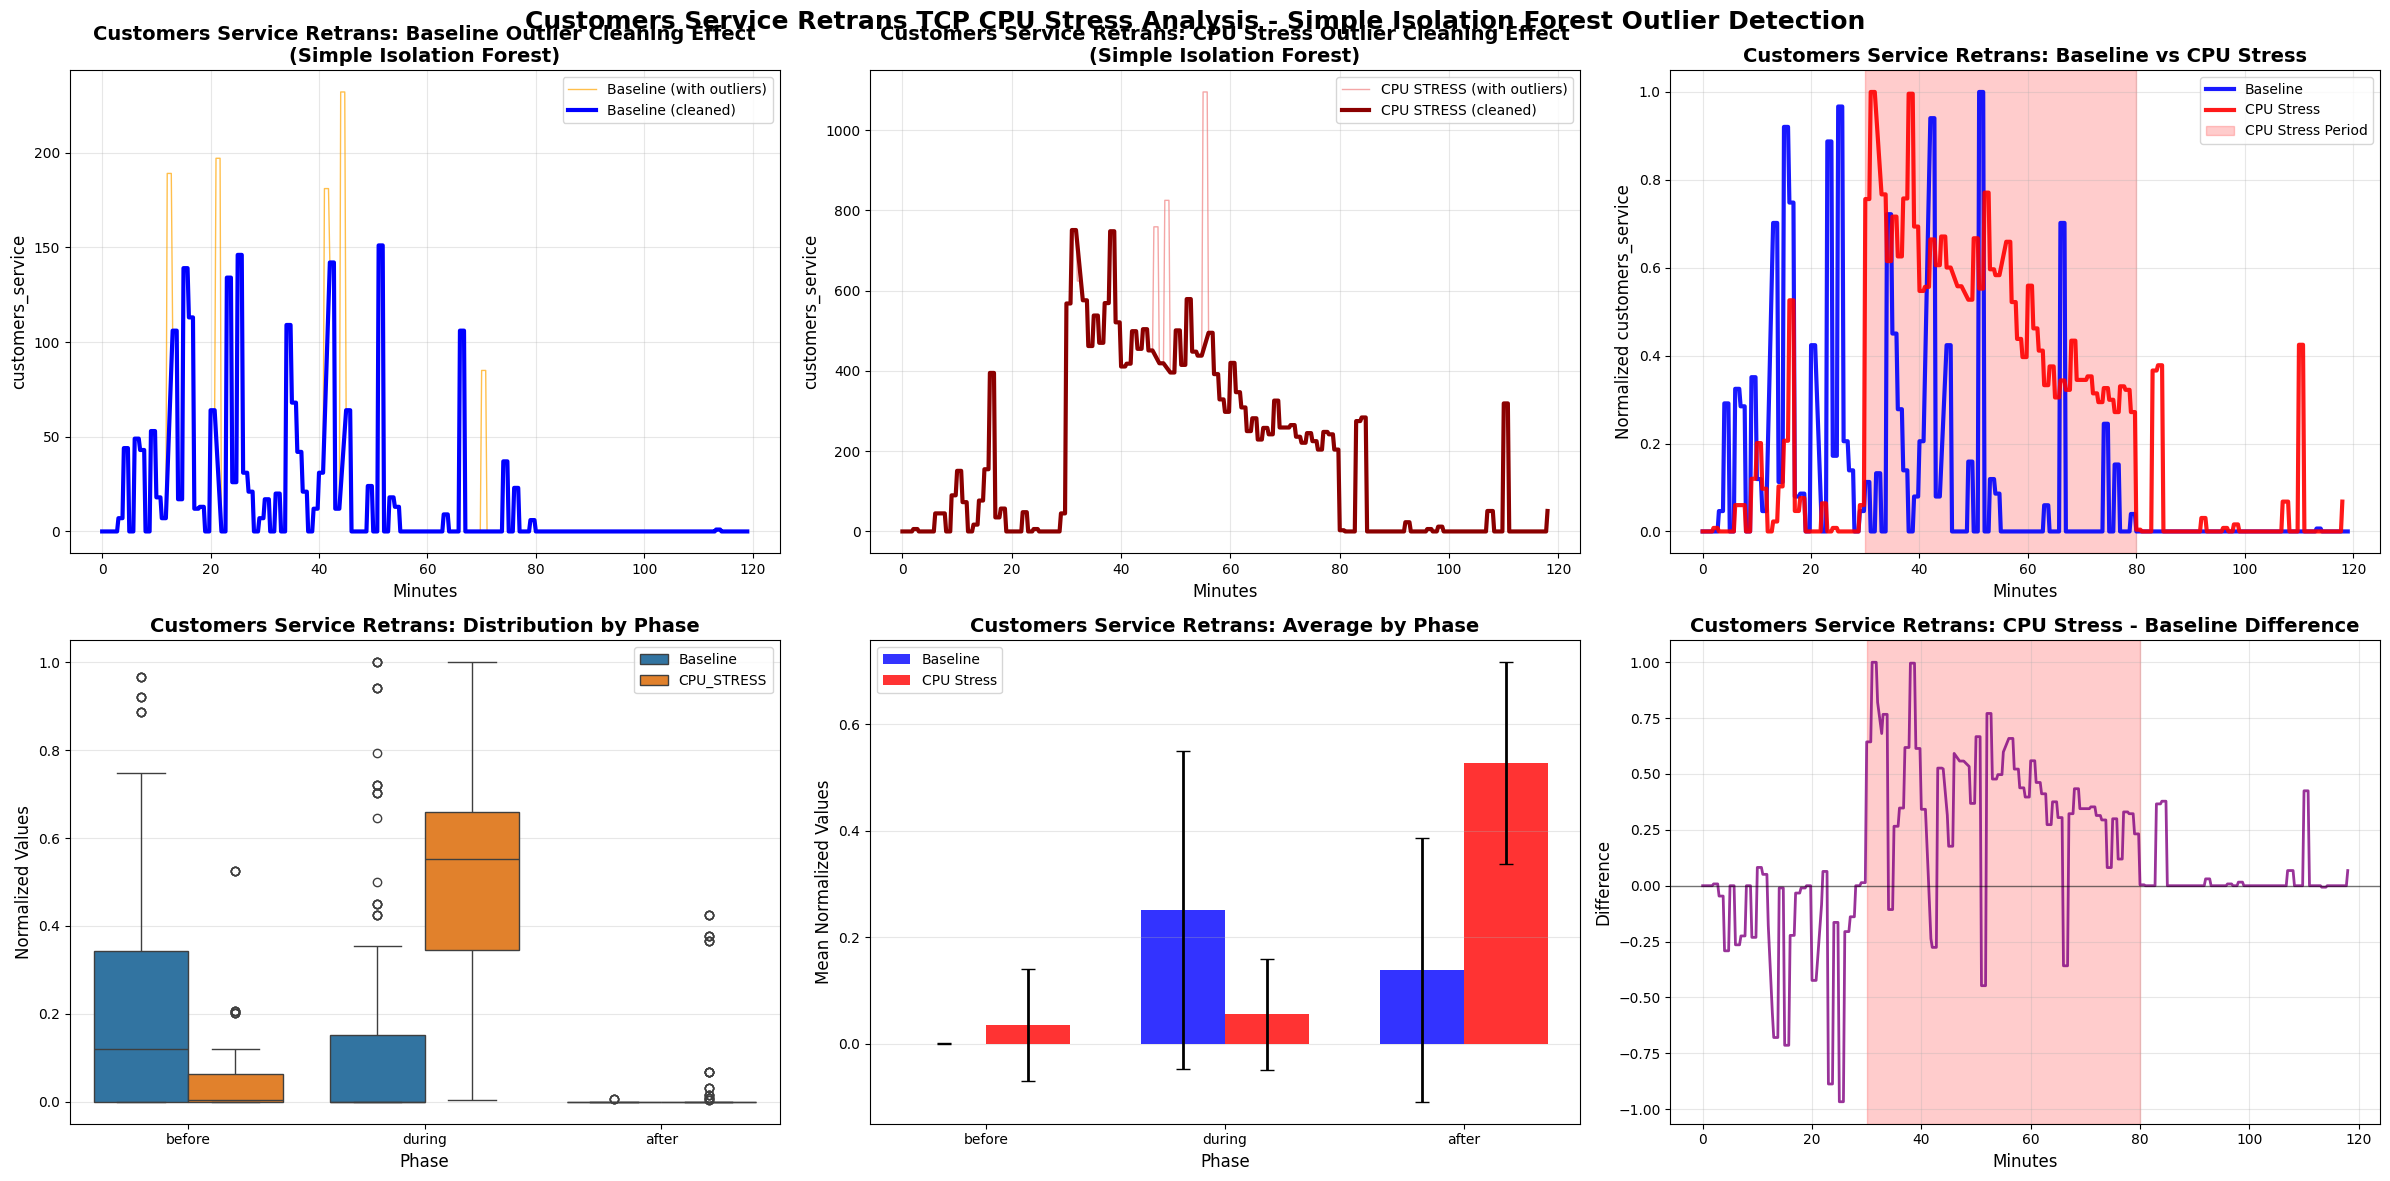


CUSTOMERS SERVICE RETRANS - TCP CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0002  0.0011  0.0  0.0066
before  0.2513  0.2988  0.0  0.9669
during  0.1383  0.2474  0.0  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.0350  0.1054  0.000  0.4248
before  0.0553  0.1046  0.000  0.5260
during  0.5272  0.1894  0.004  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  6.78, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-17.69, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -4.12, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON TCP (% CHANGE):
  BEFORE  :  -78.01% (↘️ DECREASE)
  DURING  : +281.16% (↗️ INCREASE)
  AFTER   : +20489.21% (↗️ INCREASE)

🔄 Analyzing Visits Service Retrans...


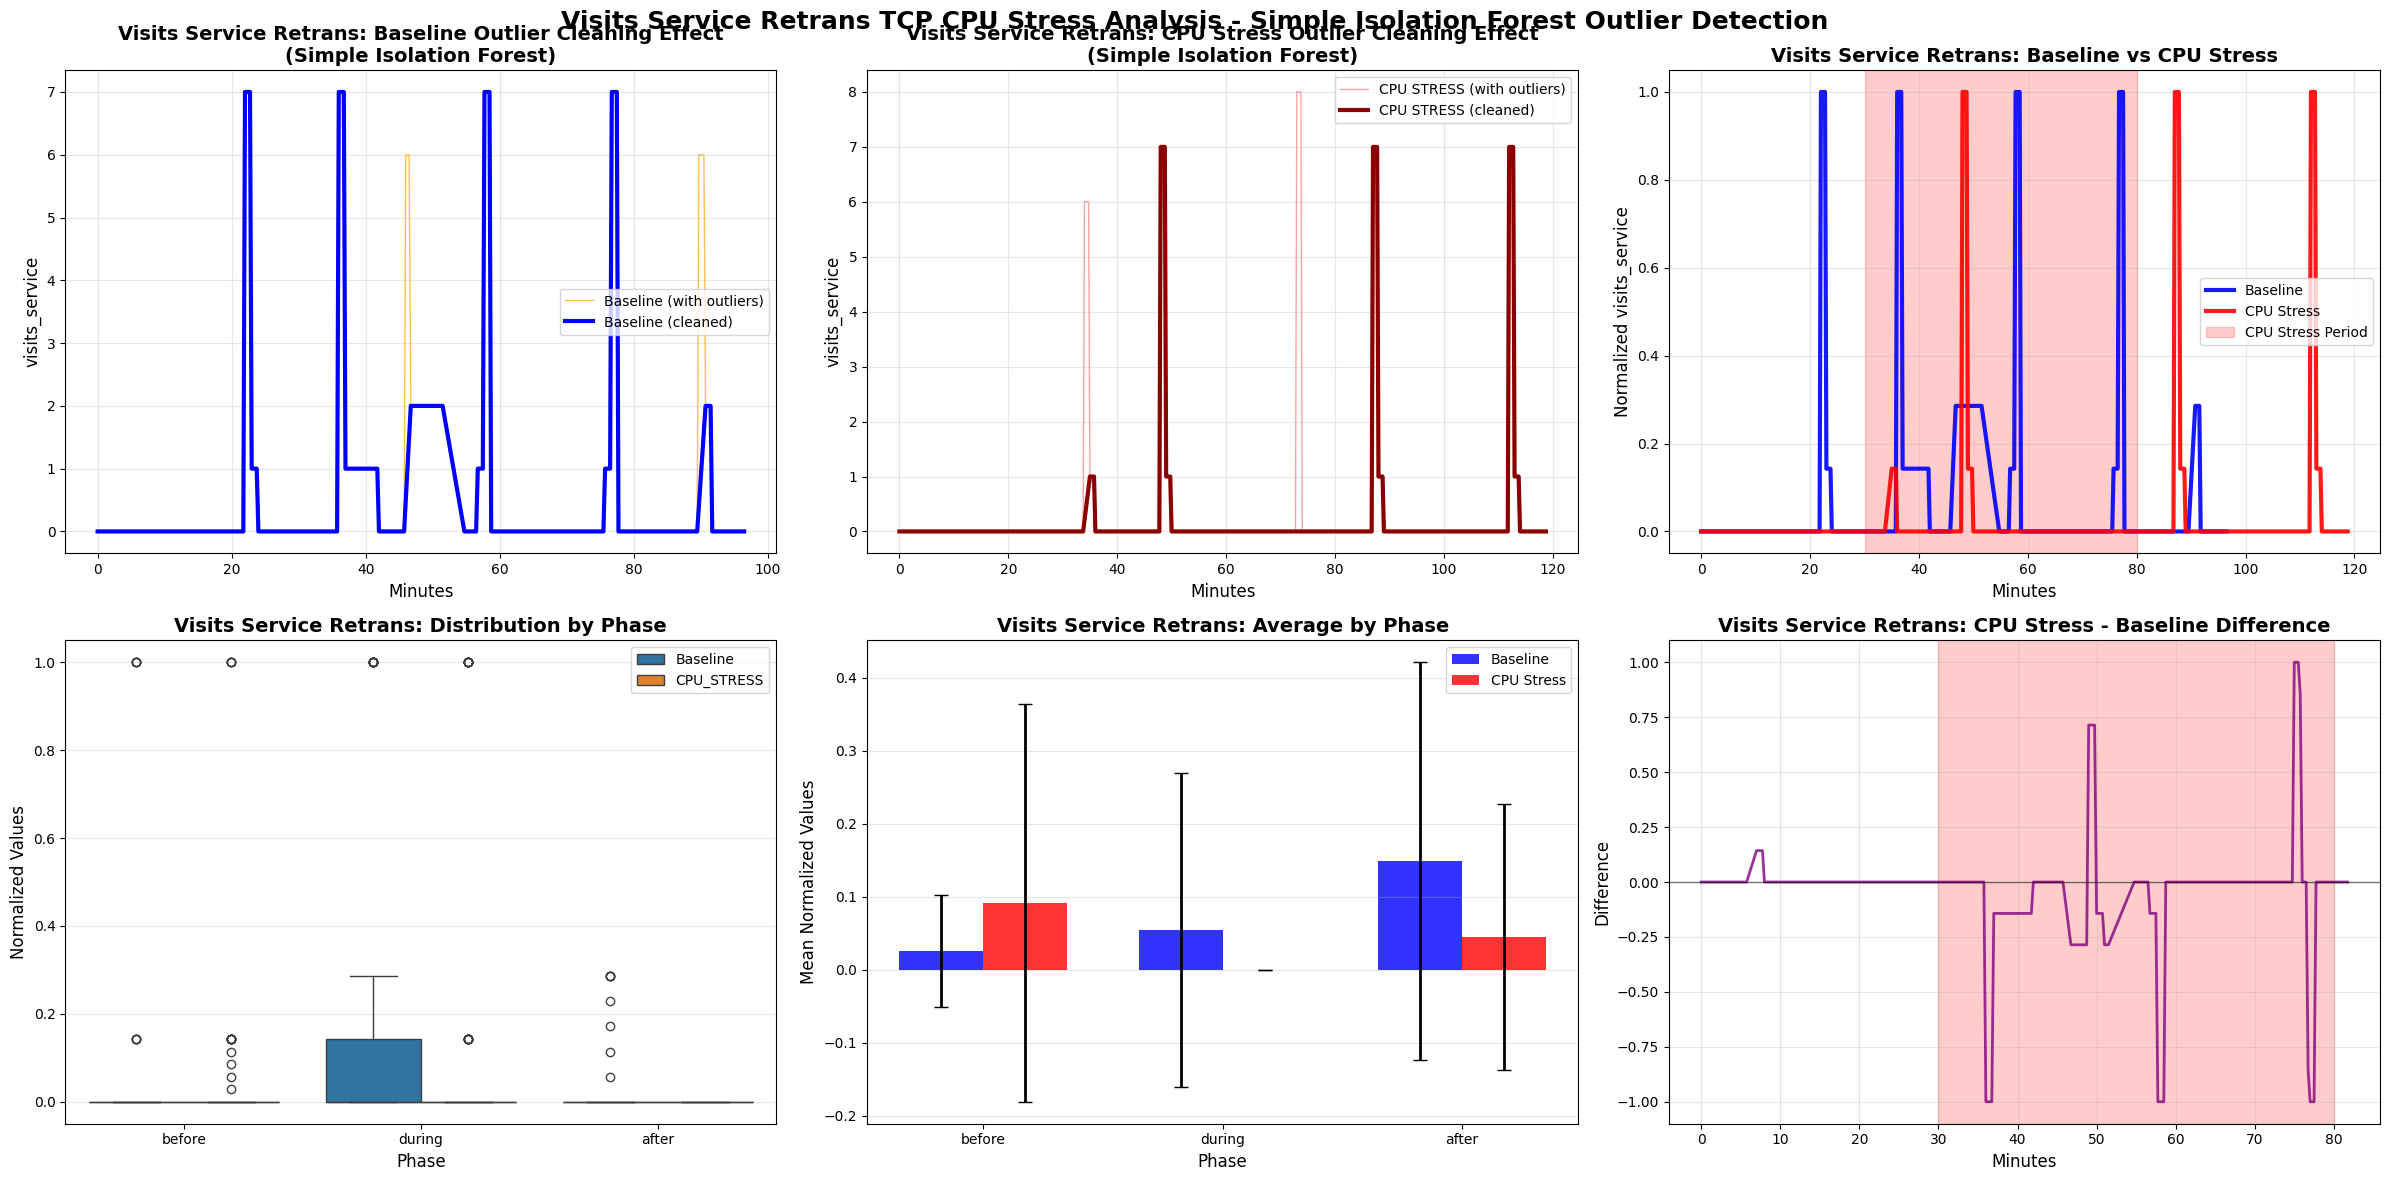


VISITS SERVICE RETRANS - TCP CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0260  0.0765  0.0  0.2857
before  0.0544  0.2149  0.0  1.0000
during  0.1486  0.2724  0.0  1.0000

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.0914  0.2721  0.0  1.0
before  0.0000  0.0000  0.0  0.0
during  0.0452  0.1820  0.0  1.0

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -0.31, p=  0.7587 (❌ NOT SIGNIFICANT)
  DURING  : t=  3.01, p=  0.0029 (✅ SIGNIFICANT)
  AFTER   : t=  0.89, p=  0.3748 (❌ NOT SIGNIFICANT)

📈 CPU STRESS IMPACT ON TCP (% CHANGE):
  BEFORE  : -100.00% (↘️ DECREASE)
  DURING  :  -69.56% (↘️ DECREASE)
  AFTER   : +252.00% (↗️ INCREASE)

🔄 Analyzing Vets Service Retrans...


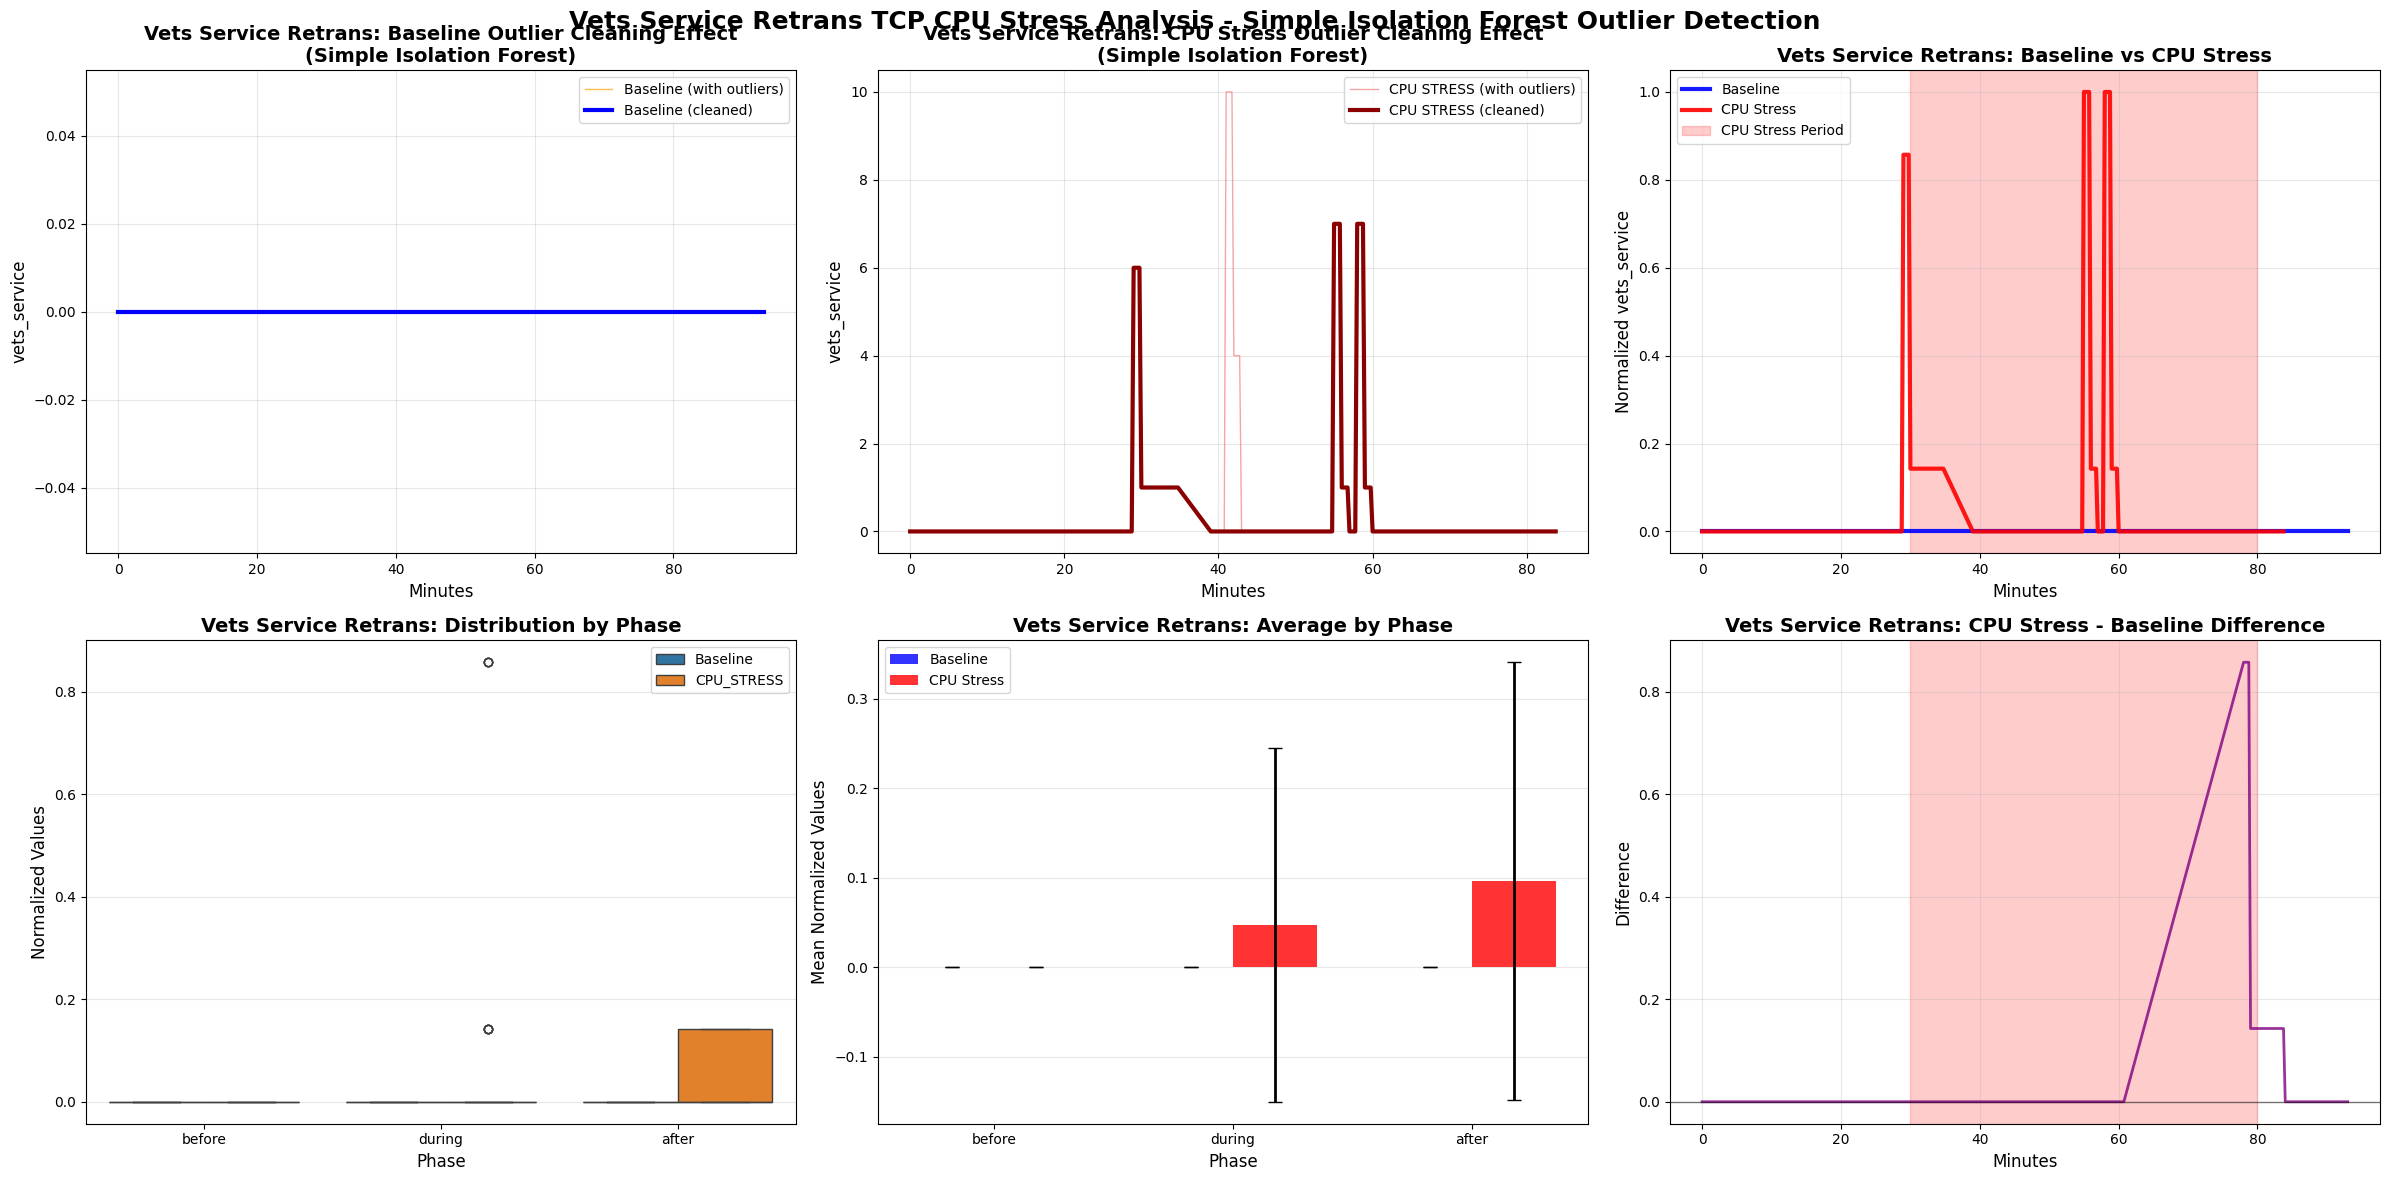


VETS SERVICE RETRANS - TCP CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
        mean  std  min  max
phase                      
after    0.0  0.0    0    0
before   0.0  0.0    0    0
during   0.0  0.0    0    0

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min     max
phase                              
after   0.0000  0.0000  0.0  0.0000
before  0.0476  0.1977  0.0  0.8571
during  0.0960  0.2446  0.0  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=   nan, p=     nan (❌ NOT SIGNIFICANT)
  DURING  : t= -2.50, p=  0.0141 (✅ SIGNIFICANT)
  AFTER   : t= -4.55, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON TCP (% CHANGE):
  BEFORE  :    +inf% (↗️ INCREASE)
  DURING  :    +inf% (↗️ INCREASE)
  AFTER   :    +inf% (↗️ INCREASE)

COMPREHENSIVE TCP CPU STRESS IMPACT SUMMARY - SIMPLE ISOLATION FOREST
               TCP_Metric        Phase   Impact (%)      P-Value  Significant  T-Statistic
          SRTT Cumulative       before       -88.7%       0.000

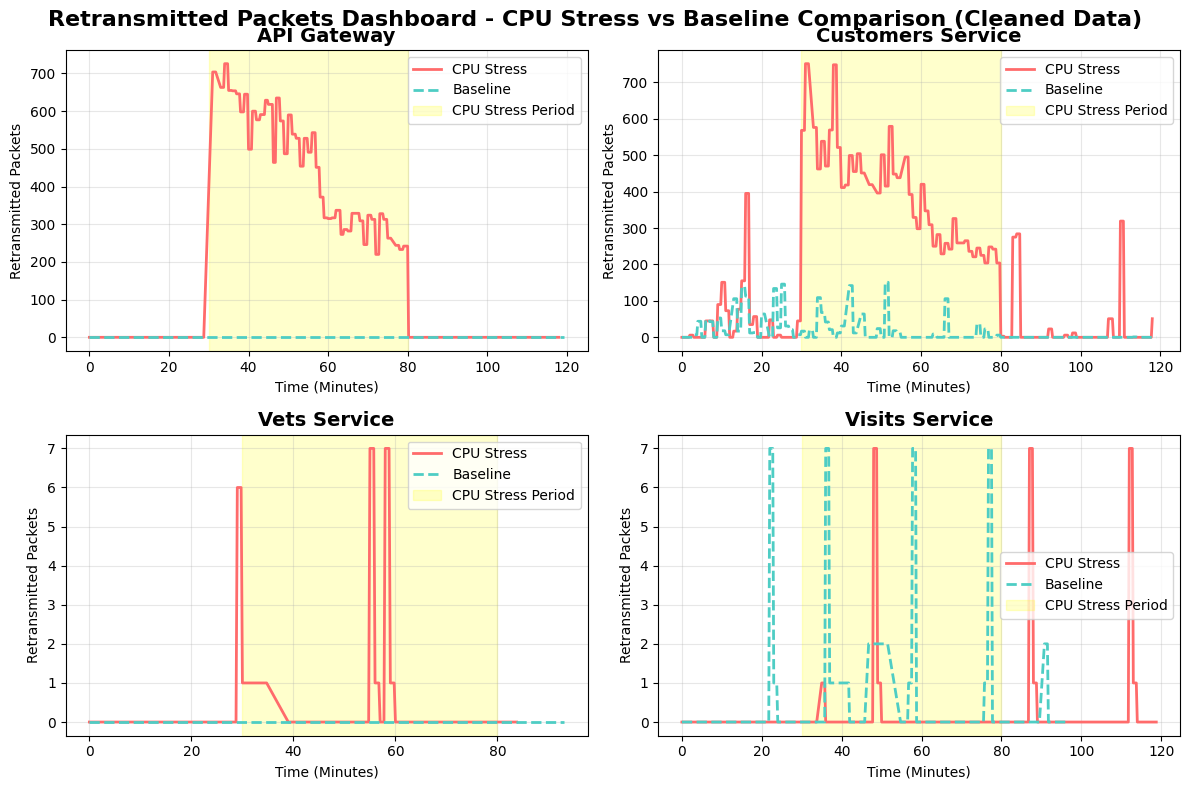


🎯 SRTT CUMULATIVE METRICS VISUALIZATION


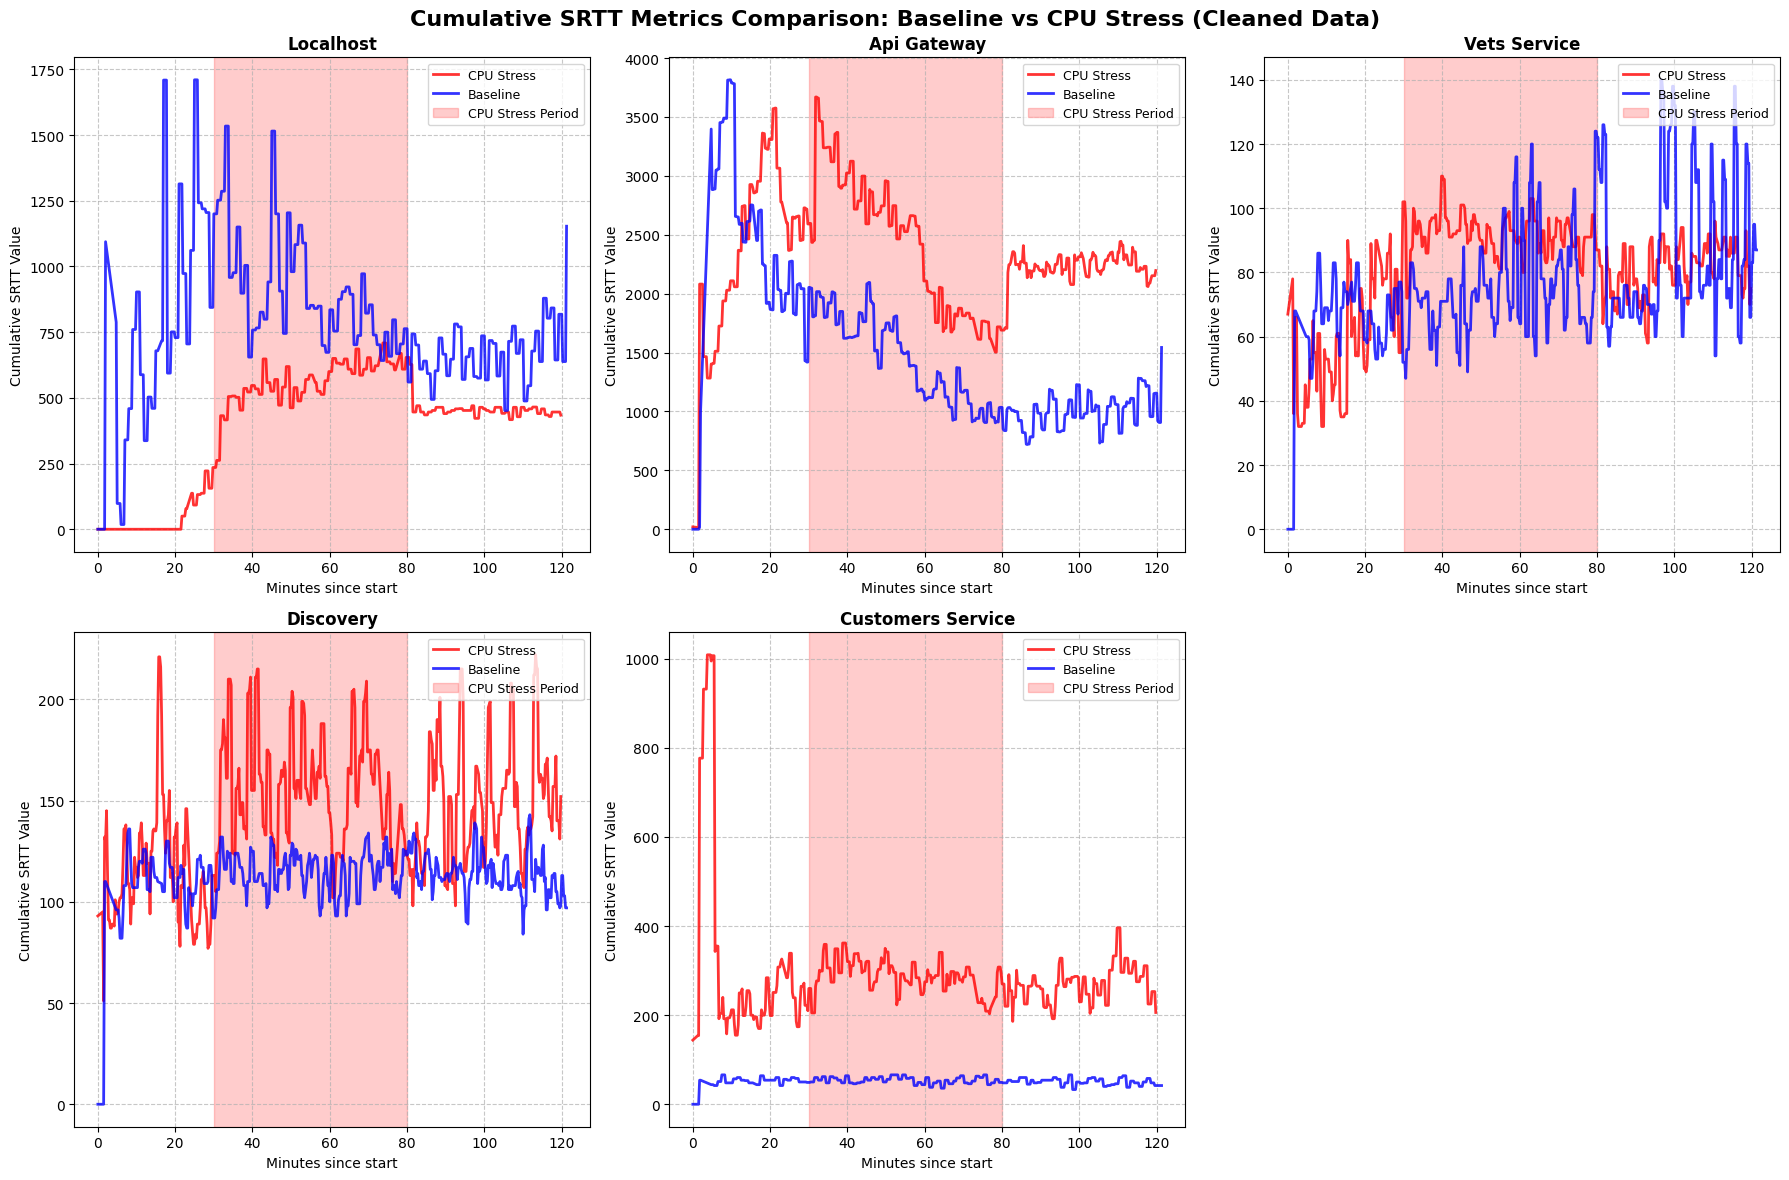

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load SRTT datasets
df_srtt = pd.read_csv("srtt.csv")
df_baseline_srtt = pd.read_csv("../../baseline/tcp related/srtt.csv")

# Load retransmitted packets datasets
df_api_gateway = pd.read_csv('./retrans_packets/api_gateway.csv')
df_customers_service = pd.read_csv('./retrans_packets/customers_service.csv')
df_visits_service = pd.read_csv('./retrans_packets/visits_service.csv')
df_vets_service = pd.read_csv('./retrans_packets/vets_service.csv')

df_api_gateway_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/api_gateway.csv")
df_customers_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/customers_service.csv")
df_vets_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/vets_service.csv")
df_visits_service_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets/visits_service.csv")

# Add source labels for tracking
df_srtt["source"] = "CPU_STRESS"
df_api_gateway["source"] = "CPU_STRESS"
df_customers_service["source"] = "CPU_STRESS"
df_visits_service["source"] = "CPU_STRESS"
df_vets_service["source"] = "CPU_STRESS"

df_baseline_srtt["source"] = "BASELINE"
df_api_gateway_baseline["source"] = "BASELINE"
df_customers_service_baseline["source"] = "BASELINE"
df_vets_service_baseline["source"] = "BASELINE"
df_visits_service_baseline["source"] = "BASELINE"

# Convert to datetime
all_datasets = [
    df_srtt, df_api_gateway, df_customers_service, df_visits_service, df_vets_service,
    df_baseline_srtt, df_api_gateway_baseline, df_customers_service_baseline, 
    df_vets_service_baseline, df_visits_service_baseline
]

for df in all_datasets:
    df["Time"] = pd.to_datetime(df["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_srtt["Time"].min() - df_srtt["Time"].min()
df_srtt["Time"] += time_offset
df_api_gateway["Time"] += time_offset
df_customers_service["Time"] += time_offset
df_visits_service["Time"] += time_offset
df_vets_service["Time"] += time_offset

# Convert timeline to minutes
for df in all_datasets:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Create cumulative SRTT metrics
def create_cumulative_metrics(df):
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}
    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        else:
            service_name = col
        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()
    for service, columns in service_groups.items():
        cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
    return cumulative_df

df_srtt_cumulative = create_cumulative_metrics(df_srtt)
df_baseline_srtt_cumulative = create_cumulative_metrics(df_baseline_srtt)

# STORE ORIGINAL DATASETS BEFORE CLEANING
original_datasets = {
    'SRTT Cumulative': {'cpustress': df_srtt_cumulative.copy(), 'baseline': df_baseline_srtt_cumulative.copy()},
    'API Gateway Retrans': {'cpustress': df_api_gateway.copy(), 'baseline': df_api_gateway_baseline.copy()},
    'Customers Service Retrans': {'cpustress': df_customers_service.copy(), 'baseline': df_customers_service_baseline.copy()},
    'Visits Service Retrans': {'cpustress': df_visits_service.copy(), 'baseline': df_visits_service_baseline.copy()},
    'Vets Service Retrans': {'cpustress': df_vets_service.copy(), 'baseline': df_vets_service_baseline.copy()}
}

# ISOLATION FOREST OUTLIER DETECTION 
def remove_outliers_isolation_forest_tcp(df, contamination=0.04):
    """Simple Isolation Forest outlier detection - uses only original numeric columns"""
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get numeric columns (exclude Time and Minutes)
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    # Use ONLY the original numeric columns - no feature engineering
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Apply Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each numeric column
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest_simple'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        # Track statistics
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        # No variance - no outliers to remove
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest_simple'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING AND TRACK STATISTICS
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with Simple Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Apply Isolation Forest outlier detection
        df_clean, stats = remove_outliers_isolation_forest_tcp(df, contamination=0.04)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        features_used = stats['_summary']['features_used']
        percentage_removed = stats['_summary']['percentage_removed']
        print(f"    ✅ Cleaned {total_outliers} outliers ({percentage_removed:.1f}%) using {features_used} original features")

# NORMALIZATION FUNCTION
def normalize_df_tcp(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# FIXED ANALYSIS AND PLOT FUNCTION FOR TCP CPU STRESS
def analyze_and_plot_tcp_dataset_wide(dataset_name, cpustress_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    
    # Get original datasets for comparison
    cpustress_df_original = original_datasets[dataset_name]['cpustress']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    # Get numeric columns
    numeric_cols = [col for col in cpustress_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    cpustress_norm = normalize_df_tcp(cpustress_df_clean, numeric_cols)
    baseline_norm = normalize_df_tcp(baseline_df_clean, numeric_cols)
    
    # Determine main metric
    if 'cumulative' in dataset_name.lower():
        cumulative_cols = [col for col in numeric_cols if col.endswith('_cumulative')]
        if cumulative_cols:
            main_metric = cumulative_cols[0]
        else:
            main_metric = numeric_cols[0] if numeric_cols else None
    else:
        main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        print(f"No numeric columns found for {dataset_name}")
        return None
    
    cpustress_norm = add_phase_column(cpustress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_cpustress = cpustress_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'CPU_STRESS': cpustress_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpustress_norm[main_metric] - baseline_norm[main_metric]
    })
    
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpustress_mean = stats_cpustress.loc[phase, 'mean']
        impact[phase] = ((cpustress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING (FIXED TO SHOW ORIGINAL VS CLEANED)
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_metric], 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_metric], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Simple Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect 
    plt.subplot(2, 3, 2)
    plt.plot(cpustress_df_original['Minutes'], cpustress_df_original[main_metric], 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpustress_df_clean['Minutes'], cpustress_df_clean[main_metric], 
             label='CPU STRESS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress Outlier Cleaning Effect\n(Simple Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpustress_norm['Minutes'], cpustress_norm[main_metric], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpustress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpustress['mean'], yerr=stats_cpustress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: CPU Stress - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} TCP CPU Stress Analysis - Simple Isolation Forest Outlier Detection', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - TCP CPU STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpustress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT ON TCP (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpustress': stats_cpustress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE TCP CPU STRESS ANALYSIS - SIMPLE ISOLATION FOREST")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpustress_clean = datasets_clean[dataset_name]['cpustress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_tcp_dataset_wide(
        dataset_name, 
        cpustress_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL COMPREHENSIVE SUMMARY
print(f"\n{'='*100}")
print("COMPREHENSIVE TCP CPU STRESS IMPACT SUMMARY - SIMPLE ISOLATION FOREST")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:
        for phase in ['before', 'during', 'after']:
            summary_table.append({
                'TCP_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}"
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))

# OUTLIER DETECTION SUMMARY
print(f"\n{'='*80}")
print("SIMPLE ISOLATION FOREST OUTLIER DETECTION SUMMARY")
print(f"{'='*80}")

for dataset_name, outlier_data in all_outlier_stats.items():
    print(f"\n📊 {dataset_name.upper()}:")
    for source_type, stats in outlier_data.items():
        if '_summary' in stats:
            summary = stats['_summary']
            print(f"  {source_type.upper()}:")
            print(f"    Total outliers removed: {summary['total_outliers']}")
            print(f"    Percentage removed: {summary['percentage_removed']:.1f}%")
            print(f"    Features used: {summary['features_used']} (original columns only)")
            print(f"    Contamination rate: {summary['contamination_rate']*100:.1f}%")

# Retransmitted packets dashboard using cleaned data
print(f"\n🎯 RETRANSMITTED PACKETS DASHBOARD")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Retransmitted Packets Dashboard - CPU Stress vs Baseline Comparison (Cleaned Data)', fontsize=16, fontweight='bold')

retrans_datasets = [
    ('API Gateway', datasets_clean['API Gateway Retrans']['cpustress'], datasets_clean['API Gateway Retrans']['baseline'], 'api_gateway'),
    ('Customers Service', datasets_clean['Customers Service Retrans']['cpustress'], datasets_clean['Customers Service Retrans']['baseline'], 'customers_service'),
    ('Vets Service', datasets_clean['Vets Service Retrans']['cpustress'], datasets_clean['Vets Service Retrans']['baseline'], 'vets_service'),
    ('Visits Service', datasets_clean['Visits Service Retrans']['cpustress'], datasets_clean['Visits Service Retrans']['baseline'], 'visits_service')
]

for i, (title, test_df, baseline_df, metric_col) in enumerate(retrans_datasets):
    ax = axes[i//2, i%2]
    ax.plot(test_df['Minutes'], test_df[metric_col], 
           label='CPU Stress', linewidth=2, color='#FF6B6B')
    ax.plot(baseline_df['Minutes'], baseline_df[metric_col], 
           label='Baseline', linewidth=2, color='#4ECDC4', linestyle='--')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Time (Minutes)')
    ax.set_ylabel('Retransmitted Packets')
    ax.axvspan(delay, delay + duration, color='yellow', alpha=0.2, label="CPU Stress Period")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# SRTT cumulative visualization using cleaned data
print(f"\n🎯 SRTT CUMULATIVE METRICS VISUALIZATION")
print("=" * 50)

cumulative_metrics = [col for col in datasets_clean['SRTT Cumulative']['cpustress'].columns if col.endswith('_cumulative')]
key_cumulative_metrics = cumulative_metrics[:5] if len(cumulative_metrics) >= 5 else cumulative_metrics

if key_cumulative_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cumulative SRTT Metrics Comparison: Baseline vs CPU Stress (Cleaned Data)', fontsize=16, fontweight='bold')
    axes_flat = axes.flatten()

    for i, metric in enumerate(key_cumulative_metrics):
        if i < len(axes_flat):
            ax = axes_flat[i]
            ax.plot(datasets_clean['SRTT Cumulative']['cpustress']["Minutes"], datasets_clean['SRTT Cumulative']['cpustress'][metric], 
                   label="CPU Stress", color='red', linewidth=2, alpha=0.8)
            ax.plot(datasets_clean['SRTT Cumulative']['baseline']["Minutes"], datasets_clean['SRTT Cumulative']['baseline'][metric], 
                   label="Baseline", color='blue', linewidth=2, alpha=0.8)
            ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="CPU Stress Period")
            service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
            ax.set_title(f'{service_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel("Minutes since start", fontsize=10)
            ax.set_ylabel("Cumulative SRTT Value", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(loc='upper right', fontsize=9)

    # Remove unused subplots
    for i in range(len(key_cumulative_metrics), len(axes_flat)):
        fig.delaxes(axes_flat[i])

    plt.tight_layout()
    plt.show()
else:
    print("No cumulative metrics found for SRTT visualization.")